In [ ]:
!pip install shapely
!pip install fiona
!pip install pyproj

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 33.8 MB/s eta 0:00:00


Inport the modules and mount Google Drive

In [ ]:
# import fiona
# import shapely
# import pyproj
# import os, os.path
# from fiona.crs import from_epsg

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import time
import numpy as np
import requests
from PIL import Image
from matplotlib import pyplot as plt
import io
import os, os.path
import pandas as pd

In [ ]:
%%bash
# Colab-specific setup
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
pip install yacs 2>&1 >> install.log
git init 2>&1 >> install.log
git remote add origin https://github.com/CSAILVision/semantic-segmentation-pytorch.git 2>> install.log
git pull origin master 2>&1 >> install.log
DOWNLOAD_ONLY=1 ./demo_test.sh 2>> install.log

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
From https://github.com/CSAILVision/semantic-segmentation-pytorch
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master


In [ ]:
# System libs
import os, csv, torch, numpy, scipy.io, PIL.Image, torchvision.transforms
# Our libs
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode

colors = scipy.io.loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')

    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # aggregate images and save
    im_vis = numpy.concatenate((img, pred_color), axis=1)
    display(PIL.Image.fromarray(im_vis))

In [ ]:
# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()
segmentation_module.cuda()

In [ ]:
# Load and normalize one image as a singleton tensor batch
pil_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
        std=[0.229, 0.224, 0.225])  # across a large photo dataset.
])
# pil_image = PIL.Image.open('ADE_val_00001519.jpg').convert('RGB')
# img_original = numpy.array(pil_image)
# img_data = pil_to_tensor(pil_image)
# singleton_batch = {'img_data': img_data[None].cuda()}
# output_size = img_data.shape[1:]

In [ ]:

!mkdir streetview
!unzip '/content/drive/My Drive/streetview.zip' -d streetview


In [ ]:
# gsvdir = os.path.join(root, 'gsvimgs')
# gsvdir
from pathlib import Path

gsvdir = Path('./streetview')

for file in os.listdir(gsvdir):
  filename = os.path.join(gsvdir, file)
  # if idx > 5: break
  print(filename)

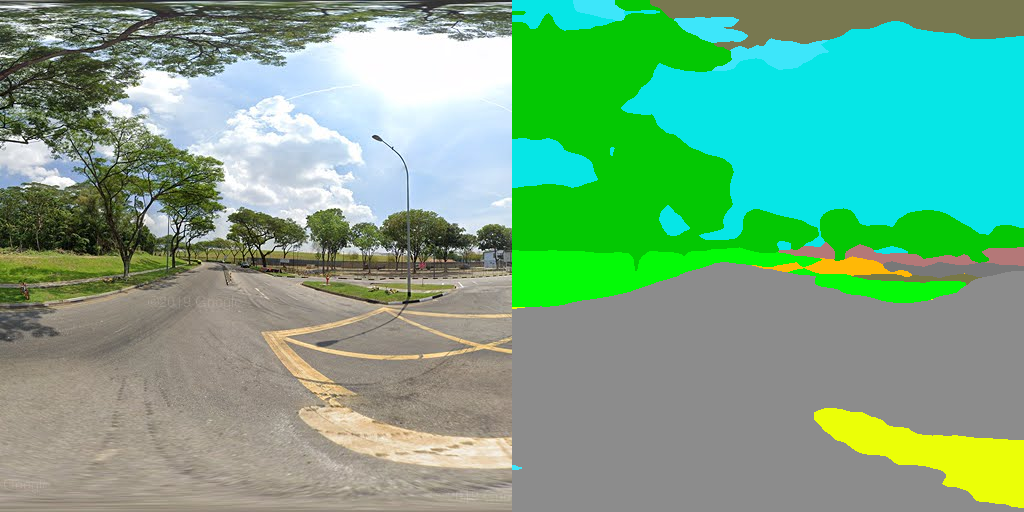

In [ ]:
import os, os.path
from pathlib import Path

pil_image = PIL.Image.open("./streetview/tile_1_37.jpeg").convert('RGB')
img_original = numpy.array(pil_image)
img_data = pil_to_tensor(pil_image)
singleton_batch = {'img_data': img_data[None].cuda()}
output_size = img_data.shape[1:]

# Run the segmentation at the highest resolution.
with torch.no_grad():
    scores = segmentation_module(singleton_batch, segSize=output_size)

# Get the predicted scores for each pixel
_, pred = torch.max(scores, dim=1)
pred = pred.cpu()[0].numpy()

visualize_result(img_original, pred)

In [ ]:
def count_non_black_pxl(img):
  return(np.sum(img[:,:,0] + img[:,:,1] + img[:,:,2] >= 0))

count_non_black_pxl(img_original)

np.int64(262144)

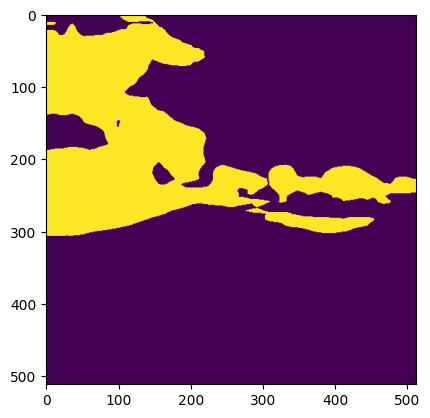

In [ ]:
from matplotlib import pyplot as plt
plt.imshow((pred == 9) | (pred == 4))

## Compute the Green View Index


In [ ]:
def get_gvi():
  x_lst = []
  y_lst = []
  gvi_lst = []
  gvi_adj_lst = []

  for idx, file in enumerate(os.listdir(gsvdir)):

    # Get the grid coordinates of the file
    filename = os.path.join(gsvdir, file)
    x = filename.split(sep="_")[1]
    y = filename.split(sep="_")[2].split(".")[0]

    pil_image = PIL.Image.open(filename).convert('RGB')
    img_original = numpy.array(pil_image)
    img_data = pil_to_tensor(pil_image)
    singleton_batch = {'img_data': img_data[None].cuda()}
    output_size = img_data.shape[1:]

    # Run the segmentation at the highest resolution.
    with torch.no_grad():
        scores = segmentation_module(singleton_batch, segSize=output_size)

    # Get the predicted scores for each pixel
    _, pred = torch.max(scores, dim=1)
    pred = pred.cpu()[0].numpy()
    # visualize_result(img_original, pred)

    greenPxlNum = len(np.where((pred == 9) | (pred == 4))[0])
    gvi = greenPxlNum / ( img_original.shape[0] * img_original.shape[1] )
    gvi_adj = greenPxlNum / count_non_black_pxl(img_original)

    # print('The GVI is:', gvi)

    # Save results
    x_lst.append(x)
    y_lst.append(y)
    gvi_lst.append(gvi)
    gvi_adj_lst.append(gvi_adj)

  out = pd.DataFrame({
      'x': x_lst,
      'y': y_lst,
      'gvi': gvi_lst,
      'gvi_adj' : gvi_adj_lst
  })

  return(out, x_lst, y_lst, gvi_lst, gvi_adj_lst)




In [ ]:
# Execute
out, x_lst, y_lst, gvi_lst, gvi_adj_lst = get_gvi()

In [ ]:
out.to_csv('output.csv', index=False)